In [1]:
from PIL import Image
import numpy as np
import tensorflow as tf
import time

import os
import sys

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

/Users/ywu58/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/ywu58/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### DNN

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './dnn_model_64_64', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11c25cfd0>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./dnn_model_64_64/model.ckpt-72000
INFO:tensorflow:Saving checkpoints for 72001 into ./dnn_model_64_64/model.ckpt.
INFO:tensorflow:loss = 0.036289915, step = 72001
INFO:tensorflow:global_step/sec: 458.091
INFO:tensorflow:loss = 0.04186069, step = 72101 (0.219 sec)
INFO:tensorflow:global_step/sec: 520.194
INFO:tensorflow:loss = 0.043304

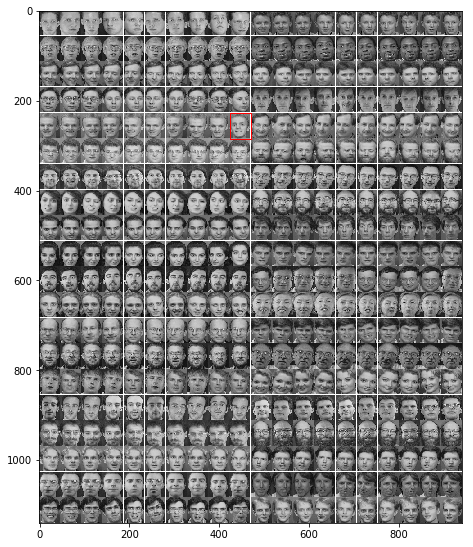

In [2]:
# -*-coding:utf-8-*-#

from PIL import Image
import numpy as np
import tensorflow as tf
import time

import os
import sys

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches


def load_data(dataset_path):
    img = Image.open(dataset_path)
	# image_ndarray is a [1140, 942, 1] 2D array for 'olivetifaces.gif'
	# value range for each pixel is [0, 255] as a gray image.
	# /255 normalize the vlaue to [0, 1]
    img_ndarray = np.asarray(img, dtype='float64') / 255

	# img_ndarray contains 20 lines and each line has 20 face images, 20 x 20 = 400 in total.
	# 40 person and 10 image per person
    # Approximately, each facial image size is 57 * 47
	# faces is a 2D array, 400 is number of faces image, 57*47 is size for each image
    faces = np.empty((400, 57 * 47))

	# Fill faces, row by row, from left to right
    for row in range(20):
        for column in range(20):
            faces[20 * row + column] = np.ndarray.flatten(
                img_ndarray[row * 57: (row + 1) * 57, column * 47 : (column + 1) * 47]
            )

    # Label for faces, the first 10 faces are person_0, second 10 faces are person_1, etc.
	# We store the label as a metric, label[i,j]=1 means image_i is person_j, label[i,j]=0 means image_i is NOT person_j.
    label = np.zeros((400, 1))
    for i in range(40):
        label[i * 10: (i + 1) * 10] = i

    # Split data into train/validate/test data.
	# Train dataset includes first 8 images for each person.
	# Validate dataset includes 9th image for each person.
	# Test dataset includes 10th image for each person.
    train_data = np.empty((320, 57 * 47))
    train_label = np.zeros((320, 1))
    vaild_data = np.empty((40, 57 * 47))
    vaild_label = np.zeros((40, 1))
    test_data = np.empty((40, 57 * 47))
    test_label = np.zeros((40, 1))

    for i in range(40):
        train_data[i * 8: i * 8 + 8] = faces[i * 10: i * 10 + 8]
        train_label[i * 8: i * 8 + 8] = label[i * 10: i * 10 + 8]

        vaild_data[i] = faces[i * 10 + 8]
        vaild_label[i] = label[i * 10 + 8]

        test_data[i] = faces[i * 10 + 9]
        test_label[i] = label[i * 10 + 9]

    # Return the three dataset the corresponding labels
    return [
        (train_data, train_label),
        (vaild_data, vaild_label),
        (test_data, test_label)
    ]


def plot(error_index, dataset_path):
    img = mpimg.imread(dataset_path)
    plt.imshow(img)
    currentAxis = plt.gca()
    for index in error_index:
        row = index // 2
        column = index % 2
        currentAxis.add_patch(
            patches.Rectangle(
                xy=(
                     47 * 9 if column == 0 else 47 * 19,
                     row * 57
                    ),
                width=47,
                height=57,
                linewidth=1,
                edgecolor='r',
                facecolor='none'
            )
    )
    fig = plt.gcf()
    fig.set_size_inches(11.40, 9.42)
    plt.savefig("fig_result.png", bbox_inches="tight", dpi=100)
    plt.show()


def train():
    # Load and pre-process images
    dataset = load_data('./olivettifaces.gif')
    train_set_x, train_set_y = dataset[0]
    vaild_set_x, valid_set_y = dataset[1]
    test_set_x, test_set_y = dataset[2]
    
    feature_columns = [tf.feature_column.numeric_column("x", shape=[57*47])]
	
    hidden_units = [64,64]
    model_dir = "./dnn_model"
    for unit in hidden_units:
        model_dir += "_" + str(unit)
    
    # Define DNN classifier
    classifier = tf.estimator.DNNClassifier(
        feature_columns=feature_columns,
        hidden_units=hidden_units,
        optimizer=tf.train.GradientDescentOptimizer(1e-4),
        n_classes=40,
        model_dir=model_dir
    )
    
    # Input function for training, it defines where to find training images, labels.
    # Also defines batch size.
    # Shuffle means randomly select from training dataset
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": train_set_x},
        y=train_set_y.astype(np.int32),
        num_epochs=None,
        batch_size=40,
        shuffle=True
    )
    
    # Train the model ans save models in model_dir.
    classifier.train(input_fn=train_input_fn, steps=2000)
    
    # Input function for testing, including testing images and labels.
    # Different from training, we test on the whole test dataset, do not need to specify batch_size and shuffle.
    test_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": test_set_x},
        y=test_set_y.astype(np.int32),
        num_epochs=1,
        shuffle=False
    )
    
    test_result = classifier.evaluate(input_fn=test_input_fn)
    print(test_result["accuracy"])
    
    test_predictions = classifier.predict(input_fn=test_input_fn)
    predicted_classes = [p["classes"] for p in test_predictions]
        
    incorrect_index = []
    for i in range(0, 40):
        if int(predicted_classes[i][0]) != i:
            incorrect_index.append(i)
            print('picture person is %i, but mis-predicted as person %i'
                %(i, int(predicted_classes[i][0])))
    
    plot(incorrect_index, "./olivettifaces.gif")


if __name__ == '__main__':
    train()
